In [161]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, resnet, sim
#from cfgs.fedargs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [163]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Gender: ResNet</h1>

In [164]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Eyeglasses'])

df1 = df[df['Eyeglasses'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 13193


,Male
202541.jpg,1
202568.jpg,1
202588.jpg,1
202590.jpg,1
202597.jpg,1


In [165]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [166]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202541.jpg,1,2
202568.jpg,1,2
202588.jpg,1,2
202590.jpg,1,2
202597.jpg,1,2


In [167]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202541.jpg,1,2
202568.jpg,1,2
202588.jpg,1,2
202590.jpg,1,2
202597.jpg,1,2


In [168]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


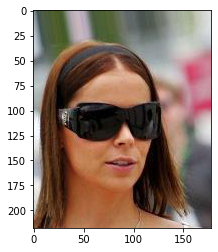

In [169]:
img = Image.open('../../data/celeba/img_align_celeba/000373.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [170]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [172]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [131]:
target_model = resnet.ResNet18(2)
target_model.load_state_dict(torch.load("../../out/models/celeba(feg_meg)_(eyeglasses)_3e.pth", map_location ='cpu'))
target_model.eval()
print("Model Loaded")

Model Loaded


<h1>SHAP Explain</h1>

In [173]:
target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images
    
target_explain = shap.DeepExplainer(target_model, target_baseline)

In [175]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())

torch.Size([3, 128, 128])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


shap_sum 2712.873036564459
shap_sum 2770.3191380345233


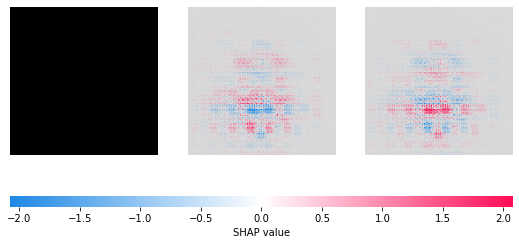

In [176]:
_target_shap_values = shap_plot(target_explain, r_img, 49152)

In [177]:
target_shap_values = torch.tensor(_target_shap_values)
target_shap_values.shape

torch.Size([2, 1, 3, 128, 128])

<h1>MS_FS</h1>

shap_sum 1298.215651189487
shap_sum 1276.804665036626


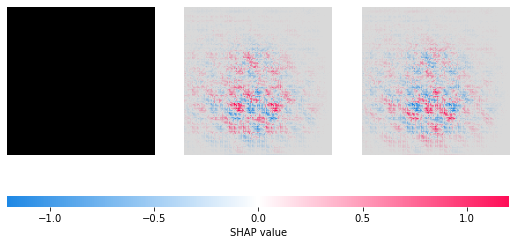

In [117]:
ms_fs_model = resnet.ResNet18(2)
ms_fs_model.load_state_dict(torch.load("../../out/models/celeba(mns_fns)_8000_2000_3e.pth", map_location ='cpu'))
ms_fs_model.eval()
ms_fs_explain = shap.DeepExplainer(ms_fs_model, target_baseline)
ms_fs_shap_values = shap_plot(ms_fs_explain, r_img, 49152)

<h1>MNS_FNS</h1>

shap_sum 1545.6179358404218
shap_sum 1571.0069298690596


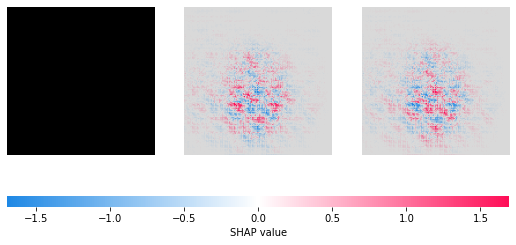

In [60]:
mns_fns_model = resnet.ResNet18(2)
mns_fns_model.load_state_dict(torch.load("../../out/models/celeba(mns_fns)_8000_2000_3e.pth", map_location ='cpu'))
mns_fns_model.eval()
mns_fns_explain = shap.DeepExplainer(mns_fns_model, target_baseline)
mns_fns_shap_values = shap_plot(mns_fns_explain, r_img, 49152)

<h1>MS_FNS</h1>

shap_sum 1545.6177450003481
shap_sum 1571.0041724544299


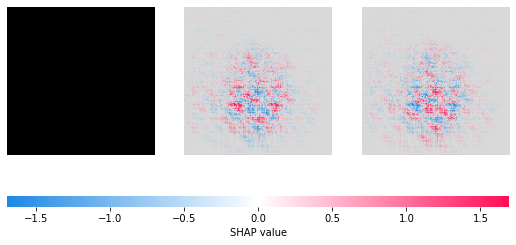

In [61]:
ms_fns_model = resnet.ResNet18(2)
ms_fns_model.load_state_dict(torch.load("../../out/models/celeba(mns_fns)_8000_2000_3e.pth", map_location ='cpu'))
ms_fns_model.eval()
ms_fns_explain = shap.DeepExplainer(ms_fns_model, target_baseline)
ms_fns_shap_values = shap_plot(ms_fns_explain, r_img, 49152)

<h1>MNS_FS</h1>

shap_sum 1545.6189295710967
shap_sum 1571.0017275835398


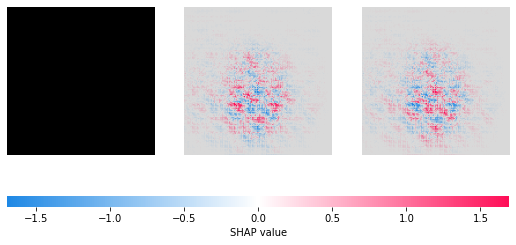

In [62]:
mns_fs_model = resnet.ResNet18(2)
mns_fs_model.load_state_dict(torch.load("../../out/models/celeba(mns_fns)_8000_2000_3e.pth", map_location ='cpu'))
mns_fs_model.eval()
mns_fs_explain = shap.DeepExplainer(mns_fs_model, target_baseline)
mns_fs_shap_values = shap_plot(mns_fs_explain, r_img, 49152)

<h1>Cosine Similarity<h1>

In [ ]:
r_shap_female = torch.tensor(target_shap_values[0]).view(-1)
r_shap_male = torch.tensor(target_shap_values[1]).view(-1)

In [ ]:
ms_fs_female = torch.tensor(ms_fs_shap_values[0]).view(-1) 
ms_fs_male = torch.tensor(ms_fs_shap_values[1]).view(-1)

In [ ]:
mns_fns_female = torch.tensor(mns_fns_shap_values[0]).view(-1) 
mns_fns_male = torch.tensor(mns_fns_shap_values[1]).view(-1) 

In [67]:
ms_fns_female = torch.tensor(ms_fns_shap_values[0]).view(-1) 
ms_fns_male = torch.tensor(ms_fns_shap_values[1]).view(-1) 

In [ ]:
mns_fs_female = torch.tensor(mns_fs_shap_values[0]).view(-1) 
mns_fs_male = torch.tensor(mns_fs_shap_values[1]).view(-1) 

In [ ]:
print(sim.cosine_similarity(r_shap_female, ms_fs_female))
print(sim.cosine_similarity(r_shap_female, mns_fns_female))
print(sim.cosine_similarity(r_shap_female, ms_fns_female))
print(sim.cosine_similarity(r_shap_female, mns_fs_female))

In [ ]:
print(sim.cosine_similarity(r_shap_m
                            
                            ale, ms_fs_male))
print(sim.cosine_similarity(r_shap_male, mns_fns_male))
print(sim.cosine_similarity(r_shap_male, ms_fns_male))
print(sim.cosine_similarity(r_shap_male, mns_fs_male))

shap_sum 2574.0161407352634
shap_sum 2633.7994764907185


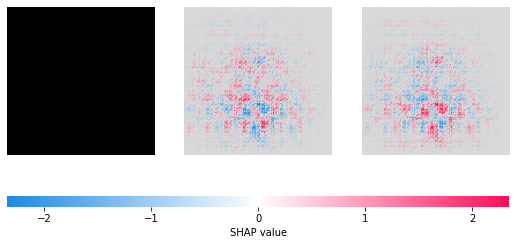

In [140]:
#MNEG_FNEG
ms_fns_model = resnet.ResNet18(2)
ms_fns_model.load_state_dict(torch.load("../../out/models/celeba(mneg_fneg)_5k_5k_3e.pth", map_location ='cpu'))
ms_fns_model.eval()
ms_fns_explain = shap.DeepExplainer(ms_fns_model, target_baseline)
ms_fns_shap_values = shap_plot(ms_fns_explain, r_img, 49152)

shap_sum 1.281224921201039
shap_sum 1.0841051403104296


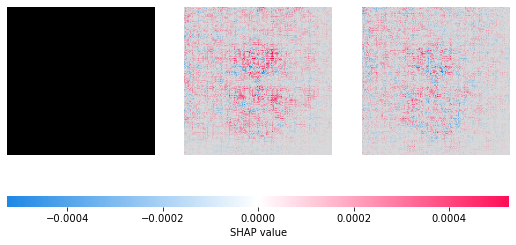

In [154]:
#Male NonEyeglasses and Female NonEyeglasses
mneg_fneg_model = resnet.ResNet18(2)
mns_fns_model.load_state_dict(torch.load("../../out/models/celeba(mneg_fneg)_5k_5k_3e.pth", map_location ='cpu'))
mneg_fneg_model.eval()
mneg_fneg_explain = shap.DeepExplainer(mneg_fneg_model, target_baseline)
mneg_fneg_shap_values = shap_plot(mneg_fneg_explain, r_img, 49152)

In [156]:
#cosine similarity
r_shap_female = torch.tensor(target_shap_values[0]).view(-1)
r_shap_male = torch.tensor(target_shap_values[1]).view(-1)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [159]:
mneg_fneg_female = torch.tensor(mneg_fneg_shap_values[0]).view(-1) 
mneg_fneg_male = torch.tensor(mneg_fneg_shap_values[1]).view(-1)

In [160]:
print(sim.cosine_similarity(r_shap_female, mneg_fneg_female))

0.064024515


shap_sum 3218.7208266112516
shap_sum 2892.0077312456597


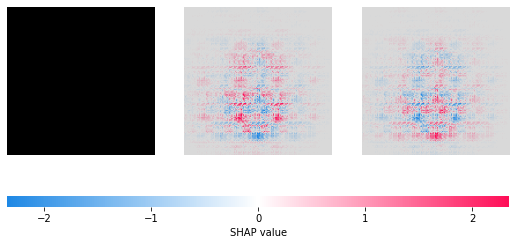

In [185]:
#Male Eyeglasses and Female Eyeglasses
meg_feg_model = resnet.ResNet18(2)
meg_feg_model.load_state_dict(torch.load("../../out/models/celeba(meg_feg)_5k_5k_3e.pth", map_location ='cpu'))
meg_feg_model.eval()
meg_feg_explain = shap.DeepExplainer(meg_feg_model, target_baseline)
meg_feg_shap_values = shap_plot(meg_feg_explain, r_img, 49152)

In [186]:
#cosine similarity
r_shap_female = torch.tensor(target_shap_values[0]).view(-1)
r_shap_male = torch.tensor(target_shap_values[1]).view(-1)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [189]:
meg_feg_female = torch.tensor(meg_feg_shap_values[0]).view(-1) 
meg_feg_male = torch.tensor(meg_feg_shap_values[1]).view(-1)

In [190]:
print(sim.cosine_similarity(r_shap_female, meg_feg_female))

0.6345824


shap_sum 6169.56418390196
shap_sum 6163.7105012523425


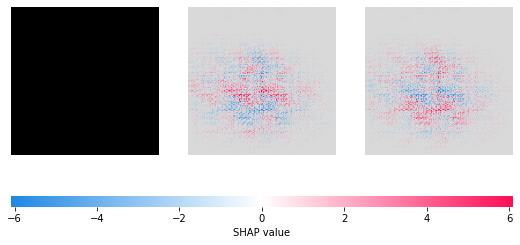

In [191]:
#Male NonEyeglasses and Female Eyeglasses
mneg_feg_model = resnet.ResNet18(2)
mneg_feg_model.load_state_dict(torch.load("../../out/models/celeba(mneg_feg)_5k_5k_3e.pth", map_location ='cpu'))
mneg_feg_model.eval()
mneg_feg_explain = shap.DeepExplainer(mneg_feg_model, target_baseline)
mneg_feg_shap_values = shap_plot(mneg_feg_explain, r_img, 49152)

In [192]:
#cosine similarity
r_shap_female = torch.tensor(target_shap_values[0]).view(-1)
r_shap_male = torch.tensor(target_shap_values[1]).view(-1)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [193]:
mneg_feg_female = torch.tensor(mneg_feg_shap_values[0]).view(-1) 
mneg_feg_male = torch.tensor(mneg_feg_shap_values[1]).view(-1)

In [194]:
print(sim.cosine_similarity(r_shap_female, mneg_feg_female))

0.23366173


shap_sum 6391.042391018655
shap_sum 6227.242464954683


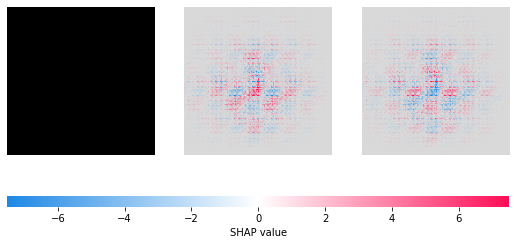

In [196]:
#Male Eyeglasses and Female NonEyeglasses
meg_fneg_model = resnet.ResNet18(2)
meg_fneg_model.load_state_dict(torch.load("../../out/models/celeba(meg_fneg)_5k_5k_3e.pth", map_location ='cpu'))
meg_fneg_model.eval()
meg_fneg_explain = shap.DeepExplainer(meg_fneg_model, target_baseline)
meg_fneg_shap_values = shap_plot(meg_fneg_explain, r_img, 49152)

In [197]:
#cosine similarity
r_shap_female = torch.tensor(target_shap_values[0]).view(-1)
r_shap_male = torch.tensor(target_shap_values[1]).view(-1)

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [198]:
meg_fneg_female = torch.tensor(meg_fneg_shap_values[0]).view(-1) 
meg_fneg_male = torch.tensor(meg_fneg_shap_values[1]).view(-1)

In [199]:
print(sim.cosine_similarity(r_shap_female, meg_fneg_female))

0.14269498


In [ ]:
#Equal number of male and female
